In [ ]:
!pip install pyprind

In [ ]:
import nltk

nltk.download('vader_lexicon')

In [ ]:
import pandas as pd

df = pd.read_excel(io = './IssueReport.xls', sheet_name = 'Raw')
df = df[['SR NUMBER', 'SR DESCRIPTION']]
df_row_count = len(df.index)

df.head(5)

In [ ]:
import re

def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    text = re.sub('\n', ' ', text)
    text = re.sub('[^a-zA-Z\ \?\!\,\.\:\;\)\(\)]', '', text)
    text = re.sub('[0-9]', '', text)
    text = re.sub('\ +', ' ', text)
    text = text.strip()
    return text

In [ ]:
import pyprind

pbar = pyprind.ProgBar(df_row_count)

for index, row in df.iterrows():
    df.at[index, 'SR DESCRIPTION CLEAN'] = preprocessor(row['SR DESCRIPTION'])
    pbar.update()
    
df.head(5)

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sentimentAnalyzer = SentimentIntensityAnalyzer()
pbar = pyprind.ProgBar(df_row_count)

for index, row in df.iterrows():
    polarity = sentimentAnalyzer.polarity_scores(df.at[index, 'SR DESCRIPTION CLEAN'])
    df.at[index, 'SR SENTIMENT NEG'] = polarity['neg']
    df.at[index, 'SR SENTIMENT NEU'] = polarity['neu']
    df.at[index, 'SR SENTIMENT POS'] = polarity['pos']
    df.at[index, 'SR SENTIMENT COMPUND'] = polarity['compound']
    pbar.update()

In [ ]:
df = df.sort_values(by = 'SR SENTIMENT NEG', ascending = False)

df.head(5)

In [ ]:
df.to_excel('./IssueReport_Sentiment.xls')

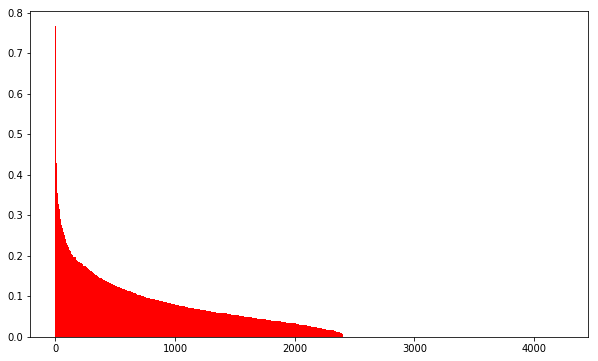

In [19]:
import matplotlib.pyplot as plt
import numpy as np

index = np.arange(df.shape[0])

plt.figure(figsize=(10, 6))
plt.bar(index, df['SR SENTIMENT NEG'], 1, color="red")
plt.show()

In [15]:
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

porter = PorterStemmer()
nltk.download('stopwords')
stop = stopwords.words('english')

def get_words():
    description_df = df[df['SR SENTIMENT NEG'] > 0.2]
    words = ' '.join(description_df['SR DESCRIPTION CLEAN'])
    words = words.lower()
    words = preprocessor(words)
    words = re.sub('[^a-z\ ]', '', words)
    words = tokenizer_porter(words)
    words = [w for w in words if w not in stop]
    words = set(words)
    return list(words)

def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

def get_words_df():
    word_set = get_words()
    data = {'WORD': word_set}
    words_df = pd.DataFrame(data)
    
    for index, row in words_df.iterrows():
        polarity = sentimentAnalyzer.polarity_scores(words_df.at[index, 'WORD'])
        words_df.at[index, 'NEG'] = polarity['neg']
    
    words_df = words_df[words_df['NEG'] > 0]
    
    return words_df
    
words_df = get_words_df()
words_df.head(5)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,WORD,NEG
26,fatal,1.0
128,doubt,1.0
143,warn,1.0
172,critic,1.0
185,delay,1.0


In [16]:
missed_words = [
'kill',
'sin',
'suspend',
'restrict',
'miss',
'low',
'argument',
'scream',
'dupe',
'distress',
'cancel',
'demand',
'exhaust',
'lower',
'kill',
'dead',
'avoid',
'mad'
];

words_df = words_df[~words_df['WORD'].isin(missed_words)]
words_df

,WORD,NEG
26,fatal,1.0
128,doubt,1.0
143,warn,1.0
172,critic,1.0
185,delay,1.0
189,reject,1.0
205,wrong,1.0
257,interrupt,1.0
258,complain,1.0
275,harm,1.0


In [ ]:
words_df.to_excel('./IssueReport_Sentiment_Words.xls')

In [17]:
print 'Negative words'

negative_words = words_df['WORD']
negative_words_dict = {}
i = 0
for word in negative_words:
    negative_words_dict[word] = i
    i = i + 1

print negative_words_dict

Negative words
{u'delay': 4, u'harm': 9, u'spam': 10, u'stuck': 18, u'problem': 19, u'error': 14, u'stop': 12, u'wrong': 6, u'destruct': 11, u'warn': 2, u'fail': 13, u'critic': 3, u'doubt': 1, u'block': 17, u'reject': 5, u'interrupt': 7, u'broken': 16, u'fatal': 0, u'complain': 8, u'conflict': 15}
